Best feature for distinguishing evergreen and deciduous: phase_crswir with ROC-AUC score: 0.7892286622241563
Optimal threshold for phase_crswir: 0.8757011273591082
Overall Accuracy: 0.8696340638570895
Kappa: 0.739773349026714
True Positives: 131326
True Negatives: 143821
False Positives: 29984
False Negatives: 11263
                             GRECO Region  Accuracy     Kappa  True Positives  \
0         Ouest-Bretagne_et_Nord-Cotentin  0.788889  0.000000               0   
1                  Massif_vosgien_central  0.767296  0.133451               5   
2                        Piémont_pyrénéen  0.602041  0.071090              19   
3          Côtes_et_plateaux_de_la_Manche  0.998106  0.000000               0   
4                        Préalpes_du_Nord  0.841286  0.000000           27362   
5                           Terres_rouges  0.973654  0.938476           40701   
6   Châtaigneraie_du_Centre_et_de_l'Ouest  0.968324  0.041493           25201   
7                       Corse_occi

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_8530/288181305.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(features, rotation=45, ha='right')


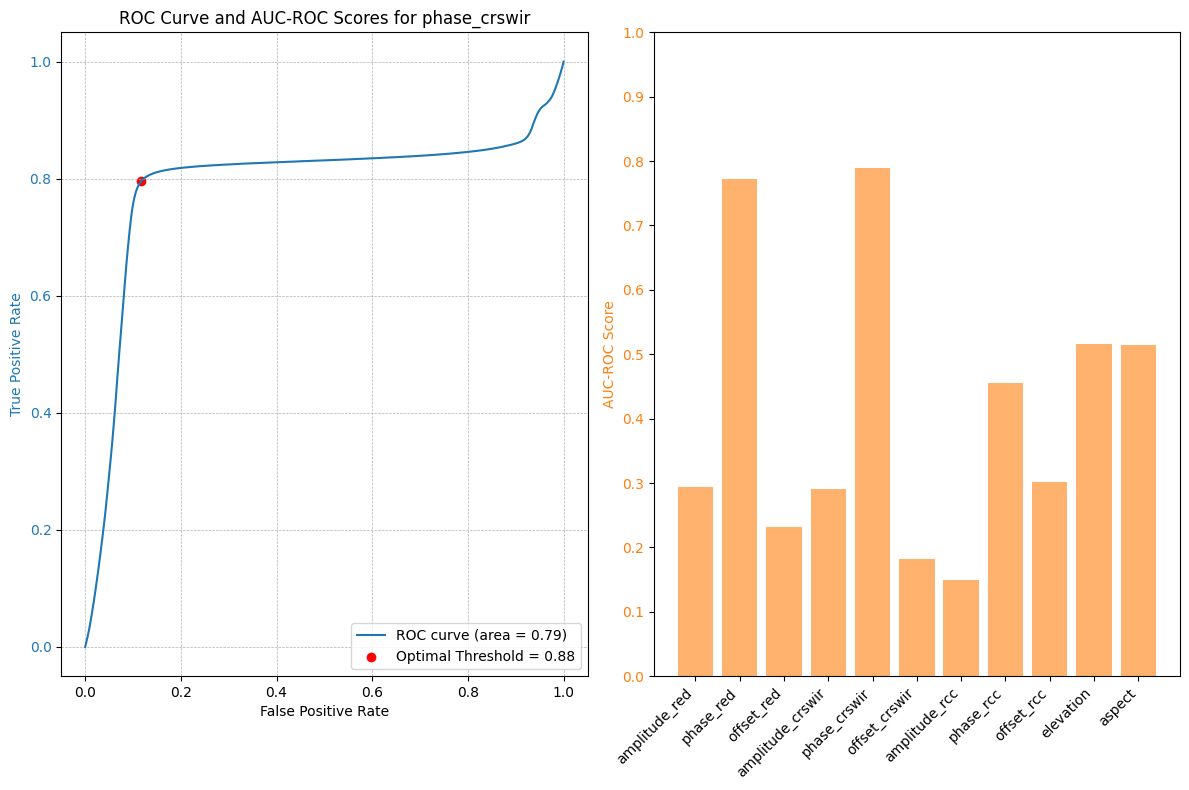

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, cohen_kappa_score

# Load the training and validation datasets
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')

# Define features and target
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X_train = train_data[features]
y_train = train_data['phen']
X_val = val_data[features]
y_val = val_data['phen']



# Select the best feature based on AUC-ROC
best_feature = None
best_roc_auc = 0
list_of_roc_auc = []
for feature in features:
    roc_auc = roc_auc_score(y_train, train_data[feature])
    list_of_roc_auc.append(roc_auc)
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_feature = feature

print(f"Best feature for distinguishing evergreen and deciduous: {best_feature} with ROC-AUC score: {best_roc_auc}")

# Compute the optimal threshold for the best feature
fpr, tpr, thresholds = roc_curve(y_train, train_data[best_feature], pos_label=2)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for {best_feature}: {optimal_threshold}")

# Apply the threshold to the validation set
val_data['predicted_phen'] = np.where(val_data[best_feature] >= optimal_threshold, 2, 1)

# Compute metrics on the validation set
accuracy = accuracy_score(y_val, val_data['predicted_phen'])
kappa = cohen_kappa_score(y_val, val_data['predicted_phen'])
tn, fp, fn, tp = confusion_matrix(y_val, val_data['predicted_phen'], labels=[1, 2]).ravel()

# Print overall metrics
print(f"Overall Accuracy: {accuracy}")
print(f"Kappa: {kappa}")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

# Compute breakdown per GRECO region
metrics_per_greco = []

for greco_region in val_data['greco_region'].unique():
    region_data = val_data[val_data['greco_region'] == greco_region]
    y_val_region = region_data['phen']
    y_pred_region = region_data['predicted_phen']
    
    accuracy_region = accuracy_score(y_val_region, y_pred_region)
    kappa_region = cohen_kappa_score(y_val_region, y_pred_region)
    tn, fp, fn, tp = confusion_matrix(y_val_region, y_pred_region, labels=[1, 2]).ravel()
    
    metrics_per_greco.append({
        'GRECO Region': greco_region,
        'Accuracy': accuracy_region,
        'Kappa': kappa_region,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    })

metrics_df = pd.DataFrame(metrics_per_greco)
print(metrics_df)

# Save metrics breakdown to CSV
import os 
os.makedirs('results', exist_ok=True)
metrics_df.to_csv('results/exp1_validation_metrics_per_greco_region.csv', index=False)

print("Validation metrics breakdown per GRECO region saved.")

# Plotting
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plotting the ROC curve
color = 'tab:blue'
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate', color=color)
ax1.plot(fpr, tpr, color=color, label=f'ROC curve (area = {best_roc_auc:.2f})')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='lower right')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.set_title(f'ROC Curve and AUC-ROC Scores for {best_feature}')

# Adding a second y-axis for the histogram
color = 'tab:orange'
ax2.set_ylabel('AUC-ROC Score', color=color)
ax2.bar(features, list_of_roc_auc, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_xticklabels(features, rotation=45, ha='right')

fig.tight_layout()  
plt.show()

import os 
os.makedirs('images', exist_ok=True)
fig.savefig('images/exp1_roc_auc_scores_and_features.png', dpi=300)
